In [1]:
import os
import sys
import numpy as np
from matplotlib import pyplot as plt
import cv2
import os, cv2, random
import numpy as np
import pandas as pd
%matplotlib inline
from tensorflow.python.keras import backend as K
from tensorflow.python.keras.models import Model
from tensorflow.python.keras.layers import Flatten, Dense, Dropout
from tensorflow.python.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.python.keras.optimizers import Adam
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator



In [2]:
def bgr_to_rgb(bgr):
    rgb = bgr[...,::-1]
    return rgb

def rgb_to_bgr(rgb):
    bgr = rgb[...,::-1]
    return bgr

def plot_bgr(img):
    plt.imshow(bgr_to_rgb(img))

def plot_rgb(img):
    plt.imshow(img)

def plot_gray(img):
    # img could be either (H,W) or (H,W,C)
    if len(img.shape) == 2:
        plt.imshow(img, cmap='gray')
    else:
        plt.imshow(img)

def plots(ims, is_bgr=True, figsize=(12,6), rows=1, interp=False, titles=None):
    ndims = len(ims[0].shape)
    assert ndims == 3 or ndims == 2
    if ndims == 2:  # convert grayscale images to bgr
        ims = [cv2.cvtColor(img, cv2.COLOR_GRAY2BGR) for img in ims]
    ims = np.array(ims).astype(np.uint8)
    if (ims.shape[-1] != 3):
        ims = ims.transpose((0,2,3,1))
    f = plt.figure(figsize=figsize)
    cols = len(ims)//rows if len(ims) % 2 == 0 else len(ims)//rows + 1
    for i in range(len(ims)):
        sp = f.add_subplot(rows, cols, i+1)
        sp.axis('Off')
        if titles is not None:
            sp.set_title(titles[i], fontsize=16)
        if is_bgr:
            plt.imshow(bgr_to_rgb(ims[i]), interpolation=None if interp else 'none')
        else:
            plt.imshow(ims[i], interpolation=None if interp else 'none')

In [3]:
DATASET_PATH  = '/home/nebex/Retinal'
IMAGE_SIZE    = (256, 256)
CROP_LENGTH   = 224
NUM_CLASSES   = 2
BATCH_SIZE    = 8  # try reducing batch size or freeze more layers if your GPU runs out of memory
FREEZE_LAYERS = 2  # freeze the first this many layers for training
NUM_EPOCHS    = 20
WEIGHTS_FINAL = 'model.h5'

In [4]:
def random_crop(img, random_crop_size):
    assert img.shape[2] == 3
    height, width = img.shape[0], img.shape[1]
    dy, dx = random_crop_size
    x = np.random.randint(0, width - dx + 1)
    y = np.random.randint(0, height - dy + 1)
    return img[y:(y+dy), x:(x+dx), :]


def crop_generator(batches, crop_length):
    while True:
        batch_x, batch_y = next(batches)
        batch_crops = np.zeros((batch_x.shape[0], crop_length, crop_length, 3))
        for i in range(batch_x.shape[0]):
            batch_crops[i] = random_crop(batch_x[i], (crop_length, crop_length))
        yield (batch_crops, batch_y)

In [5]:
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input,
                                   rotation_range=40,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   channel_shift_range=10,
                                   horizontal_flip=True,
                                   fill_mode='nearest')

train_batches = train_datagen.flow_from_directory(DATASET_PATH + '/train',
                                                  target_size=IMAGE_SIZE,
                                                  interpolation='bicubic',
                                                  class_mode='categorical',
                                                  shuffle=True,
                                                  batch_size=BATCH_SIZE)

Found 400 images belonging to 2 classes.


In [6]:


batch_x, batch_y = next(train_batches)
batch_x.shape

(8, 256, 256, 3)

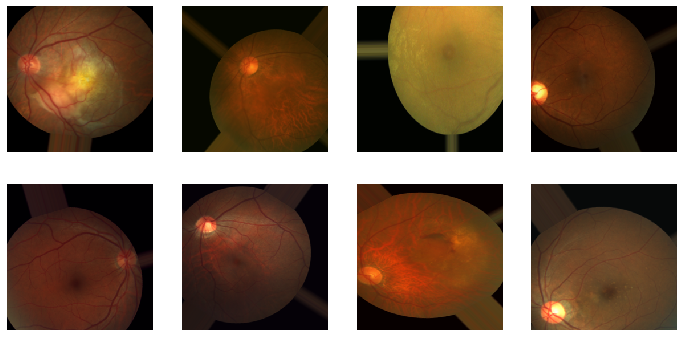

In [7]:
pixel_mean = np.array([103.939, 116.779, 123.68]).reshape((1,1,3))
plots([batch_x[i]+pixel_mean for i in range(batch_x.shape[0])], rows = 2)

In [8]:
train_crops = crop_generator(train_batches, CROP_LENGTH)

In [9]:
batch_x, batch_y = next(train_crops)
batch_x.shape

(8, 224, 224, 3)

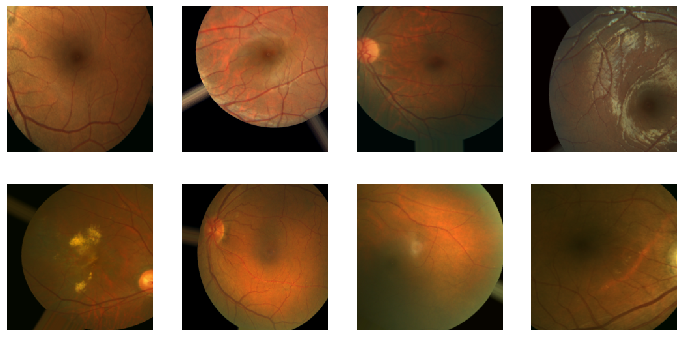

In [10]:
pixel_mean = np.array([103.939, 116.779, 123.68]).reshape((1,1,3))
plots([batch_x[i]+pixel_mean for i in range(batch_x.shape[0])], rows = 2)